## Single-Sensor, Multiple-Time Independent Component Analysis (ICA) in Frequency Domain for Moving Sources (Synthetic Dataset: Phase-Unaligned)

### Authors
* Kevin Chu (kevin@velexi.com)

### Executive Summary

In this Jupyter notebook, we investigate the use of the ICA algorithm when a single sensor is used for measurements. For a system based on a single stationary sensor, independent signal recordings (a requirement for ICA) can be acquired if we can assume that the sources are _moving relative to the sensor_.

#### Key Results

* For synthetic data _with random phase shifts between recording times_ (i.e., _not_ synchronized in phase between recording times), single-sensor, multiple-time ICA in the frequency domain is not particularly effective at extracting source signals ___without an ICA algorithm designed for complex datasets___.

  * While it is reasonable to expect the Discrete Fourier Transform (DFT) of the source signals to be invariant with time, non-aligned temporal shifts in the source signals (at different recording times) introduce _complex_ phase factors to the coefficients of the linear combination of the source signals.

  * Unfortunately, transforming the complex coefficients into real numbers (by converting from a basis of complex exponentials to a basis of sines and cosines) fails to yield good results because non-aligned temporal shifts _mixes_ coefficients (as a result of the trigonometric addition formulas), which violates the assumption ICA model assumption that each recording is a linear combination of the _same set of source signals_.

### Methods

* The Discrete Fourier Transform (DFT) performed over a short duration that balances the competing goals of using a time window that is (1) long enough to capture structure of the underlying source signals and (2) short enough that the distances from the sources to the sensor do not change significantly.

  * The norm and scaling of the DFT accounts for the factor of delta_t in the
    numerical approximation to the integral for computing Fourier coefficients.

  * The real parts of the Fourier coefficients are stored at indices of the FFT for
    positive frequencies, and the imaginary parts of the Fourier coefficients are
    stored at indices for negative frequencies.

* ICA is performed on the DFTs at different at recording times.

* The performance of ICA is evaluated by visually comparing the power spectra of extracted and pure source signals.

### Dataset

For this demonstration, we use a synthetic dataset constructed by combining audio clips for pure sources in the following manner. For additional details, See the help message for `generate-synthetic-dataset.py`.

* We randomly select initial positions (relative to the sensor) for all of the sources. The distances of the pure sources from the sensor are known; the azimuths are randomly selected.

* The heading and velocity of each source is randomly selected.

* At multiple points in time that allow for the sources to travel far enough change the strength of their signals at the sensor, we estimate the signal strength for each source and combine the pure source signals with the scaling implied by the solution of the pressure wave equation. 

* At each recording time, a random "temporal shift" is applied to each source signal before forming the sensor signal. That is, the source signals are phase-unaligned.

### Notes

* This notebook is designed to be run with any synthetic dataset located at the user-specified path.

* For the figures that appear in the version of the notebook committed to the Git repository, the following source signals were used to construct the analyzed synthetic signals:

    - pibuoy-v2-mk2-3-1663785032-hydrophone-404000-944000-368242220-ClassB-UnderWayUsingEngine-248.7.wav
    - pibuoy-v2-mk2-3-1663678653-hydrophone-423000-963000-338413036-HSC-UnderWayUsingEngine-488.4.wav
    - pibuoy-v2-mk2-3-1663340363-hydrophone-310000-850000-538006340-Cargo-UnderWayUsingEngine-461.8.wav

### History

#### 2023-03-20

- Add notes about dataset used to generate figures.

#### 2023-03-04

- Polish notebook.

#### 2023-03-01

- Finish notebook write-up.

#### 2023-02-23

- Initial revision.

### User Parameters

#### Data parameters
* `data_dir`: directory containing audio clips with temporal shifts of sources between time points
* `source_dir`: directory containing audio clips of pure sources

#### ICA parameters
* `num_active_sources`: number of active sources to attempt to extract from audio clips
* `duration`: duration of audio clip to use for analysis

#### Signal processing parameters
* `passband`: passband edge frequencies (Hz)
* `stopband`: stopband edge frequencies (Hz)
* `gpass`: maximum loss in the passband (dB)
* `gstop`: minimum attenuation in the stopband (dB)

In [1]:
# --- User parameters

import os

# Data parameters
data_dir = os.path.join("..", "data", "synthetic-single-sensor-multiple-time-with-temporal-shift")
sources_dir = os.path.join("..", "data", "pibuoy-single-source-clips")

# ICA parameters
num_active_sources = 3
duration = 20  # s

# Signal processing parameters
passband = [5, 1000]  # Hz
stopband = [1, 1500]  # Hz
gpass = 1
gstop = 100

### Preparations

In [2]:
# --- Imports

# Standard library
import glob
import math
from math import pi
import random
from typing import Optional

# External packages
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydub import AudioSegment
import pytest
from scipy import signal
import yaml

/Users/kchu/1-Work/2-Velexi/Consulting/Current-Clients/2022-Springbok-AI-Sonobuoy/work-product/IQTLabs-AISonobuoy/DataScience/ica_modeling/.direnv/python-3.10.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
# --- Plotting parameters

t_plot_end = duration  # s

### Functions

In [4]:
# --- perform_ica()

from sklearn.decomposition import FastICA

def perform_ica(data: np.ndarray,
                num_sources: Optional[int] = None,
               ) -> (np.ndarray, np.ndarray, np.ndarray):

    """
    Perform ICA on signal data.
    
    Arguments
    ---------
    * data: 2D array containing signal data. The columns of the array contains sensor data
      (1) for distinct sensors or (2) for a single sensor at distinct points in time.

    * num_sources: number of sources to extract. If `num_sources` is set to None, the
      number of sources extracted is equal to number of columns of `data`.
    
    Return values
    -------------
    * sources: array containing sources extracted by ICA as columns
    
    * source_means: array containing means of source signals estimated by ICA

    * mixing_matrix: array containing coefficients for mixing sources to obtain the
      sensor data
    """
    # --- Check arguments
    
    if num_sources is None:
        num_sources = data.shape[1]

    # --- Perform ICA

    ica = FastICA(n_components=num_sources, whiten="unit-variance")
    sources = ica.fit_transform(data)
    source_means = ica.mean_
    mixing_matrix = ica.mixing_
    
    return sources, source_means, mixing_matrix

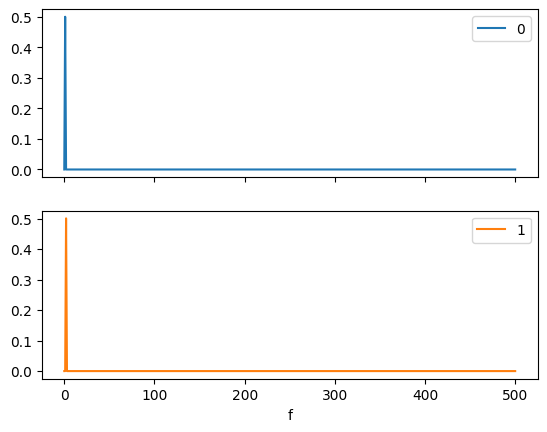

In [5]:
# --- compute_power_spectra()

from scipy import fft
import pytest

def compute_power_spectra(data: np.ndarray,
                          T: float,
                         ) -> (np.ndarray, np.ndarray):
    """
    Compute power spectrum of signals contained in `data`.
    
    Arguments
    ---------
    * data: 2D array containing signal data. Each column contains the time series for
      a single signal

    * T: length of time covered by data

    Return values
    -------------
    * power_spectra: 2D array containing power spectra of signals
    
    * frequencies: 1D array containing frequencies
    """
    # Compute DFT
    #
    # Note: we use norm = forward to correctly scale the DFT for power spectra calculations
    N = data.shape[0]
    dft = fft.fft(data, axis=0, norm="forward")
    
    # Compute frequencies
    frequencies = fft.fftfreq(N, T/N)

    # Remove redundant frequencies
    f_idx_max = int(np.ceil(N/2))
    frequencies = frequencies[0:f_idx_max+1]
    if N % 2 == 0:
        frequencies[-1] *= -1

    # Compute power spectra
    power_spectra = 1 / T * np.abs(dft[0:f_idx_max+1])**2
    
    # Account for contributions from negative frequencies
    if N % 2 == 0:
        power_spectra[1:-1] *= 2
    else:
        power_spectra[1:] *= 2

    return power_spectra, frequencies

# --- Tests

T = 1
N = 1000
t = np.linspace(0, T, num=N)
data = np.empty([N, 2])

f = 1
data[:,0] = np.sin(2 * pi * f * t)

f = 2
data[:,1] = np.cos(2 * pi * f * t)

power_spectra, frequencies = compute_power_spectra(data, T)

# Plot power spectra
plot_df = pd.DataFrame(power_spectra)
plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)
plot_df.plot(subplots=True, xlabel="f")

plt.show()
display()  # suppress matplotlib console output

# Check that power spectra has non-negligible values only at expected frequencies
locations = np.where(power_spectra > .1 / T)
for i in range(len(locations[0])):
    f = frequencies[locations[0][i]]
    p = power_spectra[locations[0][i], locations[1][i]]
    assert f in [1, 2]
    assert p == pytest.approx(0.5, rel=5e-3)

    # Set value of power_spectra at location to 0 to facilitate checking that
    # power at all other frequencies are negligible.
    power_spectra[locations[0][i], locations[1][i]] = 0
    
assert np.max(np.abs(power_spectra)) < 1e-5

In [6]:
# --- dft_freq()

def dft_freq(N: int,
             sampling_rate: float = 1.0,
             include_negative_frequencies: bool=False) -> np.ndarray:
    """
    Get frequencies for DFT.

    Arguments
    ---------
    * N: number of data points in DFT

    * sampling_rate: sampling rate
    
    * include_negative_frequencies: include negative frequencies in reverse order

    Return values
    -------------
    * f: array containing DFT frequencies. If `include_flip` is False, `f` contains
      (floor(N/2) + 1) frequencies; otherwise `f` contains `N` frequencies.
        
    Notes
    -----
    * This function is equivalent to numpy.fft.fftfreq() and scipy.fft.fftfreq()
      except that the frequency with the highest absolute value is positive.
    """
    f_max_idx = int(math.floor(N/2))
    f = fft.fftfreq(N, 1/sampling_rate)

    if N % 2 == 0:
        f[f_max_idx] *= -1
        
    if not include_negative_frequencies:
        f = f[0:f_max_idx+1]

    return f

# --- Tests

N = 10
f = dft_freq(N)
assert len(f) == math.floor(N/2) + 1
assert f[1] == 1 / N
assert np.alltrue(f >= 0)

N = 9
f = dft_freq(N)
assert len(f) == math.floor(N/2) + 1
assert f[1] == 1 / N
assert np.alltrue(f >= 0)

N = 10
f = dft_freq(N, include_negative_frequencies=True)
assert len(f) == N
assert f[1] == 1 / N
f_max_idx = math.floor(N/2)
assert np.alltrue(f[0:f_max_idx+1] >= 0)
assert np.alltrue(f[f_max_idx+1:] < 0)

N = 9
f = dft_freq(N, include_negative_frequencies=True)
assert len(f) == N
assert f[1] == 1 / N
f_max_idx = math.floor(N/2)
assert np.alltrue(f[0:f_max_idx+1] >= 0)
assert np.alltrue(f[f_max_idx+1:] < 0)

In [7]:
# --- dft_complex_to_real() and dft_real_to_complex()

def dft_complex_to_real(dft_complex: np.ndarray) -> np.ndarray:
    """
    Convert DFT of real function over basis of complex exponentials to 
    DFT over basis of cosines and sines.
    
    Arguments
    ---------
    * dft_complex: array containing DFT over basis of complex exponentials

    Return value
    ------------
    * dft_real: array containing DFT over basis of cosines and sines
    
    Notes
    -----
    * Let N be the number of points in dft_complex and f_max_idx be the index of
      the maximum frequency component. The Fourier coefficients of the cosine are
      stored in the indices 0 <= i <= f_max_idx. The Fourier coefficients of the
      sine are stored in the indices f_max_idx < i < N.

    * The order of dft_real is the same as the order generated by numpy.fft.fftfreq().
    """
    N = dft_complex.shape[0]
    dft_real = np.empty(N)

    f_max_idx = int(math.floor(N/2))
    dft_real[0:f_max_idx+1] = 2 * np.real(dft_complex[0:f_max_idx+1])
    dft_real[f_max_idx+1:] = 2 * np.imag(dft_complex[f_max_idx+1:])
    
    return dft_real

def dft_real_to_complex(dft_real: np.ndarray) -> np.ndarray:
    """
    Convert DFT of real function over basis of cosines and sines to
    DFT over basis of complex exponentials.
    
    Arguments
    ---------
    * dft_real: array containing DFT over basis of cosines and sines

    Return value
    ------------
    * dft_complex: array containing DFT over basis of complex exponentials
    
    Notes
    -----
    * Let N be the number of points in dft_complex and f_max_idx be the index of
      the maximum frequency component. The Fourier coefficients of the cosine are
      expected to be stored in the indices 0 <= i <= f_max_idx, and the Fourier
      coefficients of the sine are expected to be stored in the indices
      f_max_idx < i < N.

    * The order of dft_real must be same as the order generated by numpy.fft.fftfreq().
    """
    N = dft_real.shape[0]
    dft_complex = np.empty(N, dtype="complex")

    f_max_idx = int(math.floor(N/2))
    dft_complex[0] = 0.5 * dft_real[0]
    if N % 2 == 0:
        dft_complex[f_max_idx] = dft_real[f_max_idx]
        dft_complex[1:f_max_idx] = \
            0.5 * (dft_real[1:f_max_idx] - 1j * dft_real[:f_max_idx:-1])
        dft_complex[f_max_idx+1:] = np.conjugate(dft_complex[f_max_idx-1:0:-1])
    else:
        dft_complex[1:f_max_idx+1] = \
            0.5 * (dft_real[1:f_max_idx+1] - 1j * dft_real[:f_max_idx:-1])
        dft_complex[f_max_idx+1:] = np.conjugate(dft_complex[f_max_idx:0:-1])

    return dft_complex

# --- Tests

N = 10
t = np.linspace(0, 1, num=N, endpoint=False)
x = np.sin(2 * math.pi * t) + 3 * np.cos(6 * math.pi * t)
dft_complex = fft.fft(x, norm="forward")
dft_real = dft_complex_to_real(dft_complex)
assert dft_real[-1] == pytest.approx(1)
assert dft_real[3] == pytest.approx(3)
for i in range(N):
    if i not in [3, N-1]:
        assert dft_real[i] == pytest.approx(0)
dft_complex_test = dft_real_to_complex(dft_real)
assert np.allclose(dft_complex_test, dft_complex)

N = 9
t = np.linspace(0, 1, num=N, endpoint=False)
x = np.sin(2 * math.pi * t) + 3 * np.cos(6 * math.pi * t)
dft_complex = fft.fft(x, norm="forward")
dft_real = dft_complex_to_real(dft_complex)
assert dft_real[-1] == pytest.approx(1)
assert dft_real[3] == pytest.approx(3)
for i in range(N):
    if i not in [3, N-1]:
        assert dft_real[i] == pytest.approx(0)
dft_complex_test = dft_real_to_complex(dft_real)
assert np.allclose(dft_complex_test, dft_complex)

### Load Audio Clips

#### Multi-Source Audio Clips

In [8]:
# --- Load multi-source audio clips

audio_clips = {}
for path in glob.glob(os.path.join(data_dir, "*.wav")):
    # Read audio file
    audio = AudioSegment.from_wav(path)

    # Convert audio to DataFrame
    samples = audio.split_to_mono()[0].get_array_of_samples()
    audio_clips[os.path.basename(path)] = {
        "frame_rate": audio.frame_rate,
        "data": np.array(samples).T.astype(np.float32),
    }
    
# --- Validate data

# Check that frame rate is the same for all clips
frame_rate = None
for clip in audio_clips.values():
    if frame_rate is None:
        frame_rate = clip["frame_rate"]
    assert clip["frame_rate"] == frame_rate

# --- Convert raw audio clips to a DataFrame

audio_data = pd.DataFrame()
for key, clip in audio_clips.items():
    audio_data[key] = clip["data"]

In [9]:
# --- Transform snippets of raw audio clips to the frequency domain

audio_data_dft = pd.DataFrame()
end_idx = duration * frame_rate
for key, clip in audio_clips.items():
    dft = duration * fft.fft(clip["data"][0:end_idx], norm="forward")
    dft_real = dft_complex_to_real(dft)
    audio_data_dft[key] = dft_real

<Figure size 640x480 with 0 Axes>

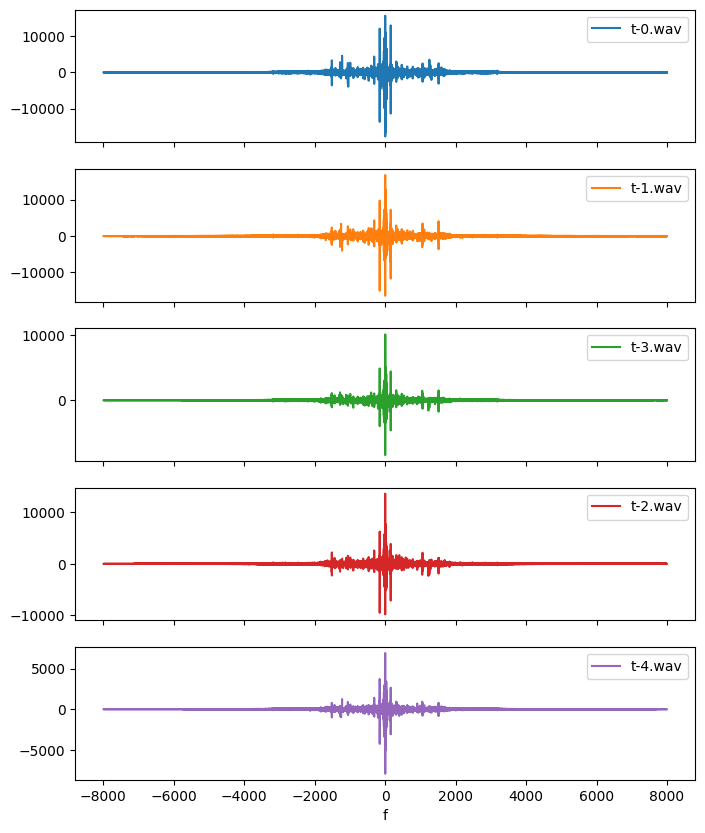

In [10]:
# --- Visually inspect DFT of audio clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
N = audio_data_dft.shape[0]
for i in range(audio_data_dft.shape[1]):
    plot_df[f"{audio_data_dft.columns[i]}"] = audio_data_dft.iloc[:, i]

plot_df["f"] = dft_freq(N, N/duration, include_negative_frequencies=True)
plot_df.set_index("f", inplace=True)

# Generate plots
plt.figure()
num_plots = len(audio_data_dft.columns)
plot_df.plot(subplots=True,
             figsize=(8, 2 * num_plots), 
             layout=(num_plots, 1),
             xlabel="f")

plt.show()
display()  # suppress matplotlib console output

#### Single-Source Audio Clips

In [11]:
# --- Load audio clips for sources

# Get list of source files
with open(os.path.join(data_dir, "sources.yaml")) as file_:
    source_files = yaml.safe_load(file_)
    
pure_source_clips = {}
for file_name in source_files:
    # Construct path to source audio file
    path = os.path.join(sources_dir, file_name)
    
    # Read audio file
    audio = AudioSegment.from_wav(path)

    # Convert audio to DataFrame
    samples = audio.split_to_mono()[0].get_array_of_samples()
    pure_source_clips[file_name] = {
        "frame_rate": audio.frame_rate,
        "num_samples": len(samples),
        "data": np.array(samples).T.astype(np.float32),
    }
    
# --- Validate data

# Check that frame rate for source slips is the same as for mixed audio clips
for clip in pure_source_clips.values():
    assert clip["frame_rate"] == frame_rate
    
# --- Convert raw audio clips to a DataFrame

pure_source_data = pd.DataFrame()
num_samples = min(clip["num_samples"] for clip in pure_source_clips.values())
for key, clip in pure_source_clips.items():
    pure_source_data[key] = clip["data"][0:num_samples]

In [12]:
# --- Transform snippets of raw audio clips to the frequency domain

pure_source_data_dft = pd.DataFrame()
end_idx = duration * frame_rate
for key, clip in pure_source_clips.items():
    dft = duration * fft.fft(clip["data"][0:end_idx], norm="forward")
    dft_real = dft_complex_to_real(dft)
    pure_source_data_dft[key] = dft_real

<Figure size 640x480 with 0 Axes>

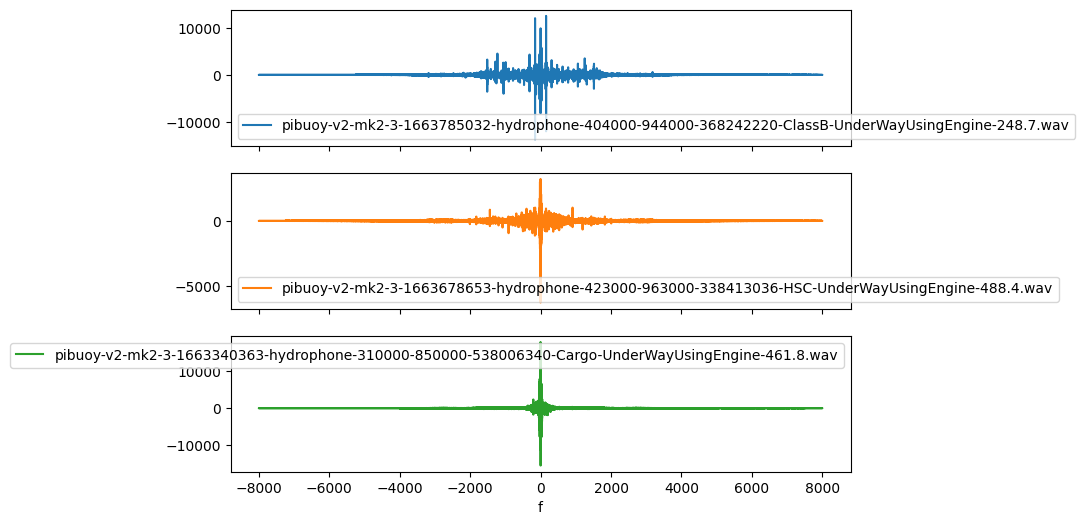

In [13]:
# --- Visually inspect DFT of pure source clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
N = audio_data_dft.shape[0]
for i in range(pure_source_data_dft.shape[1]):
    plot_df[f"{pure_source_data_dft.columns[i]}"] = pure_source_data_dft.iloc[:, i]
    
plot_df["f"] = dft_freq(N, N/duration, include_negative_frequencies=True)
plot_df.set_index("f", inplace=True)

# Generate plots
plt.figure()
num_sources = len(pure_source_clips)
t_plot_end_idx = frame_rate * t_plot_end
plot_df.plot(subplots=True, figsize=(8, 6),
             layout=(num_sources, 1),
             xlabel="f")

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

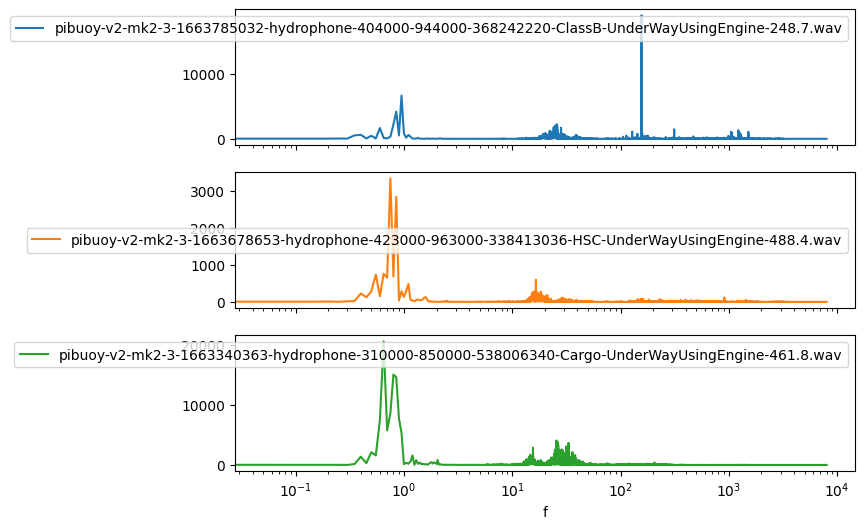

In [14]:
# --- Visually inspect power spectra of pure sources

# Compute power spectra
end_idx = duration * frame_rate
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:end_idx,:],
                                                                duration)
# Construct DataFrame for plotting
plot_df = pd.DataFrame()
for i in range(pure_source_data.shape[1]):
    plot_df[f"{pure_source_data.columns[i]}"] = power_spectra_pure_sources[:, i]

plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

# Generate plots
plt.figure()
num_sources = len(pure_source_data.columns)
plot_df.plot(subplots=True, figsize=(8, 6),
             layout=(num_sources, 1),
             logx=True,
             xlabel="f")

plt.show()
display()  # suppress matplotlib console output

### ICA Without Filtering

#### Perform ICA to Extract Sources from Audio Clips

In [15]:
# --- Perform ICA on audio clips

# Extract data to use for analysis
analysis_data = audio_data_dft.to_numpy()

# Perform ICA
sources_ica, source_means, mixing_matrix = perform_ica(analysis_data,
                                                       num_sources=num_active_sources)

<Figure size 640x480 with 0 Axes>

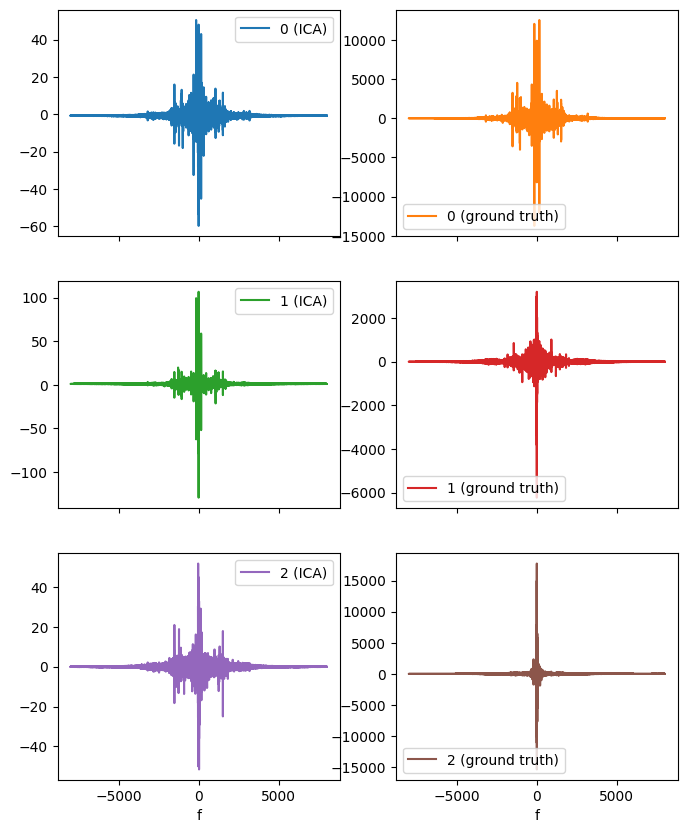

In [16]:
# --- Compare extracted source signals to pure source signals

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
N = sources_ica.shape[0]
num_plot_rows = max(sources_ica.shape[1], pure_source_data.shape[1]) 
for i in range(num_plot_rows):
    if i < sources_ica.shape[1]:    
        plot_df[f"{i} (ICA)"] = sources_ica[:, i] + source_means[i]
    else:
        plot_df["empty (ICA)"] = np.zeros(N)
    if i < pure_source_data.shape[1]:
        plot_df[f"{i} (ground truth)"] = pure_source_data_dft.iloc[:, i]
    else:
        plot_df["empty (ground truth)"] = np.zeros(N)

plot_df["f"] = dft_freq(N, N/duration, include_negative_frequencies=True)
plot_df.set_index("f", inplace=True)
        
# Generate plots
plt.figure()
plot_df.plot(subplots=True, figsize=(8, 10),
             layout=(num_plot_rows, 2),
             xlabel="f"
            )

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

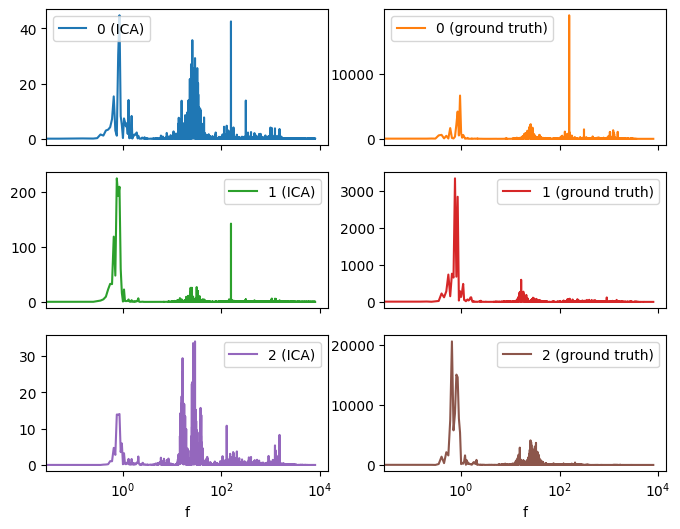

In [17]:
# --- Compare power spectra for extracted and pure source signals

# Compute power spectra
N = sources_ica.shape[0]
f_max_idx = int(math.floor(N/2))
power_spectra_ica = np.empty([f_max_idx+1, sources_ica.shape[1]])

for i in range(sources_ica.shape[1]):
    power_spectra = dft_real_to_complex(sources_ica[:,i] + source_means[i])[0:f_max_idx+1]
    power_spectra_ica[:, i] = 1 / duration * np.abs(power_spectra) ** 2

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
plot_df["f"] = dft_freq(N, N/duration)
plot_df.set_index("f", inplace=True)

t_plot_end_idx = frame_rate * t_plot_end
num_plot_rows = max(power_spectra_ica.shape[1], power_spectra_pure_sources.shape[1]) 
for i in range(num_plot_rows):
    if i < sources_ica.shape[1]:
        plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    else:
        plot_df["empty (ICA)"] = np.zeros(f_max_idx+1)
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]
    else:
        plot_df["empty (ground truth)"] = np.zeros(f_max_idx+1)

# Generate plots
fig = plt.figure()
plot_df.plot(subplots=True, figsize=(8, 2*num_plot_rows),
             layout=(num_plot_rows, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

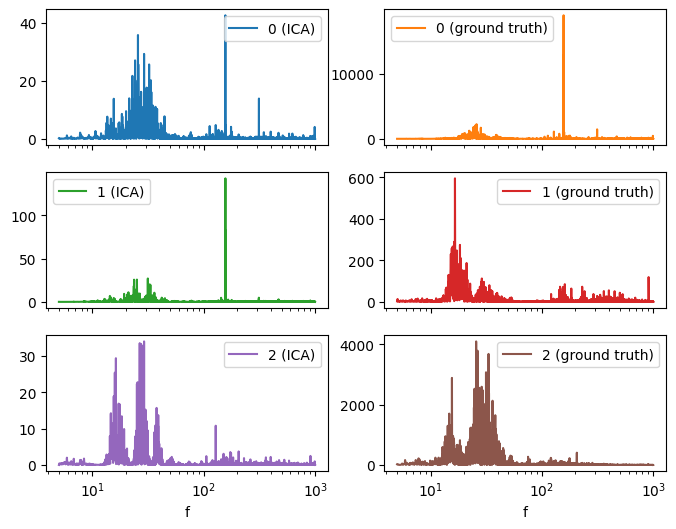

In [18]:
# --- Compare power spectra for extracted and pure source signals in pass band

# Compute power spectra
N = sources_ica.shape[0]
f_max_idx = int(math.floor(N/2))
power_spectra_ica = np.empty([f_max_idx+1, sources_ica.shape[1]])

for i in range(sources_ica.shape[1]):
    power_spectra = dft_real_to_complex(sources_ica[:,i] + source_means[i])[0:f_max_idx+1]
    power_spectra_ica[:, i] = 1 / duration * np.abs(power_spectra) ** 2

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
frequencies = dft_freq(N, N/duration)
plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

t_plot_end_idx = frame_rate * t_plot_end
num_plot_rows = max(power_spectra_ica.shape[1], power_spectra_pure_sources.shape[1]) 
for i in range(num_plot_rows):
    if i < power_spectra_ica.shape[1]:
        plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    else:
        plot_df["empty (ICA)"] = np.zeros(f_max_idx+1)
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]
    else:
        plot_df["empty (ground truth)"] = np.zeros(f_max_idx+1)

# Restrict frequency domain to frequencies in the pass band
f = frequencies[frequencies >= min(passband)]
start_idx = np.where(frequencies == f[0])[0][0]
f = f[f <= max(passband)]
end_idx = len(f) + start_idx
plot_df = plot_df.iloc[start_idx:end_idx,:]

# Generate plots
fig = plt.figure()
plot_df.plot(subplots=True, figsize=(8, 2*num_plot_rows),
             layout=(num_plot_rows, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output

### ICA With Filtering

#### Preprocess Data

In [19]:
# --- Apply filtering to remove frequencies that are not likely to originate from
#     the sources.

# Construct Butterworth filter
N, Wn = signal.buttord(passband, stopband, gpass, gstop, fs=frame_rate)
sos = signal.butter(N, Wn, btype='bandpass', output='sos', fs=frame_rate)

# Filter multi-source clips
audio_clips_filtered = pd.DataFrame()
for key, clip in audio_clips.items():
    audio_clips_filtered[key] = signal.sosfilt(sos, clip["data"])
    
# Filter pure-source clips
pure_source_clips_filtered = pd.DataFrame()
num_samples = min(clip["num_samples"] for clip in pure_source_clips.values())
for key, clip in pure_source_clips.items():
    pure_source_clips_filtered[key] = signal.sosfilt(sos, clip["data"][0:num_samples])

In [20]:
# --- Transform snippets of filtered clips to the frequency domain

audio_data_filtered_dft = pd.DataFrame()
end_idx = duration * frame_rate
for column in audio_clips_filtered.columns:
    dft = duration * fft.fft(audio_clips_filtered[column][0:end_idx].to_numpy(),
                             norm="forward")
    dft_real = dft_complex_to_real(dft)
    audio_data_filtered_dft[column] = dft_real

pure_source_data_filtered_dft = pd.DataFrame()
end_idx = duration * frame_rate
for column in pure_source_clips_filtered.columns:
    dft = duration * fft.fft(pure_source_clips_filtered[column][0:end_idx].to_numpy(),
                             norm="forward")
    dft_real = dft_complex_to_real(dft)
    pure_source_data_filtered_dft[column] = dft_real

<Figure size 640x480 with 0 Axes>

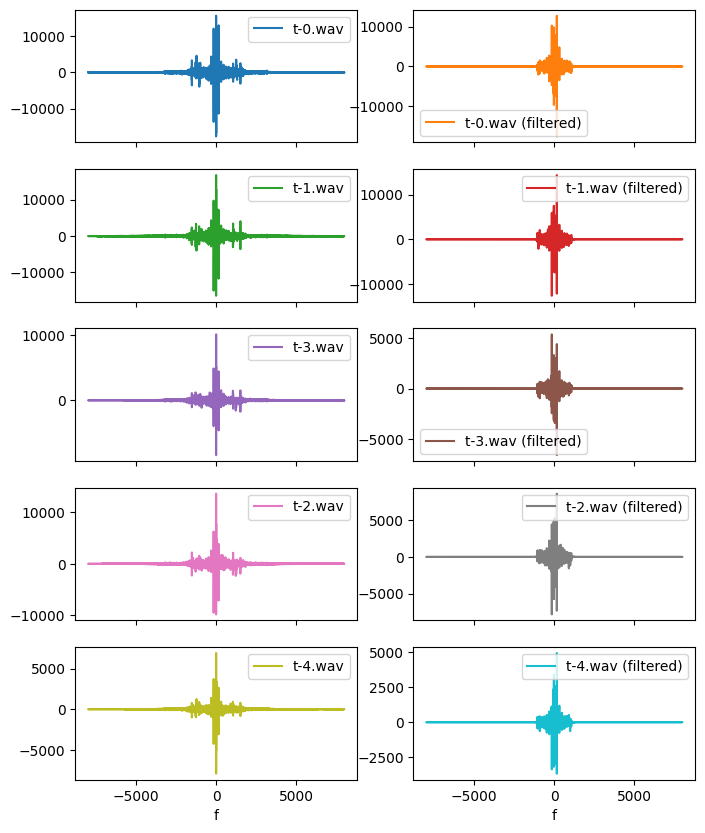

In [21]:
# --- Visually inspect DFT of filtered audio clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
N = audio_data_filtered_dft.shape[0]
for column in audio_data_filtered_dft.columns:
    plot_df[f"{column}"] = audio_data_dft[column]
    plot_df[f"{column} (filtered)"] = audio_data_filtered_dft[column]

plot_df["f"] = dft_freq(N, N/duration, include_negative_frequencies=True)
plot_df.set_index("f", inplace=True)

# Generate plots
plt.figure()
num_plots = len(audio_data_filtered_dft.columns)
plot_df.plot(subplots=True,
             figsize=(8, 10), 
             layout=(num_plots, 2),
             xlabel="f")

plt.show()
display()  # suppress matplotlib console output

#### Perform ICA to Extract Sources from Audio Clips

In [22]:
# --- Perform ICA on filtered audio clips

# Extract data to use for analysis
analysis_data_filtered = audio_data_filtered_dft.to_numpy()

# Perform ICA
(sources_ica_filtered, source_means_filtered,
 mixing_matrix_filtered) = perform_ica(analysis_data_filtered,
                                       num_sources=num_active_sources)

In [23]:
print(source_means_filtered)

[-0.14792327  0.02783463  0.04178171 -0.11166836 -0.05893603]


<Figure size 640x480 with 0 Axes>

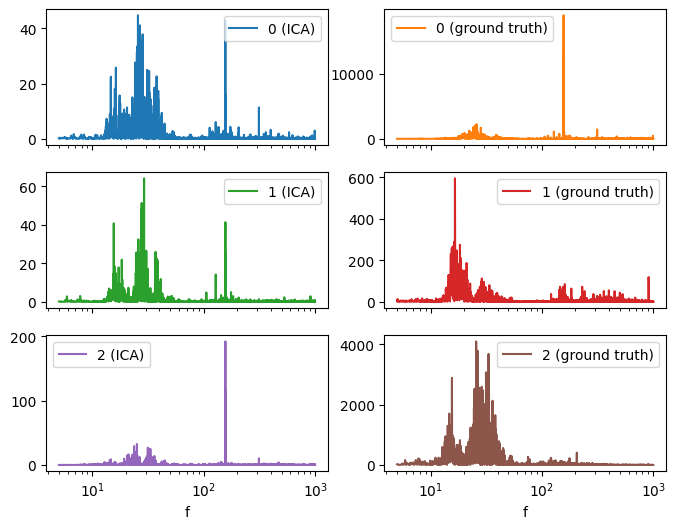

In [24]:
# --- Compare power spectra for extracted and pure source signals in pass band

# Compute power spectra
N = sources_ica_filtered.shape[0]
f_max_idx = int(math.floor(N/2))
power_spectra_ica = np.empty([f_max_idx+1, sources_ica.shape[1]])

ica_analysis_end_idx = duration * frame_rate
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:ica_analysis_end_idx,:],
                                                                duration)
for i in range(sources_ica_filtered.shape[1]):
    power_spectra = dft_real_to_complex(
        sources_ica_filtered[:,i] + source_means_filtered[i]
    )[0:f_max_idx+1]
    power_spectra_ica[:, i] = 1 / duration * np.abs(power_spectra) ** 2

# Construct DataFrame for plotting
plot_df = pd.DataFrame() 
plot_df["f"] = dft_freq(N, N/duration)
plot_df.set_index("f", inplace=True)

t_plot_end_idx = frame_rate * t_plot_end
num_plot_rows = max(power_spectra_ica.shape[1], power_spectra_pure_sources.shape[1]) 
for i in range(num_plot_rows):
    if i < power_spectra_ica.shape[1]:
        plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    else:
        plot_df["empty (ICA)"] = np.zeros(f_max_idx+1)
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]
    else:
        plot_df["empty (ground truth)"] = np.zeros(f_max_idx+1)        

# Restrict frequency domain to frequencies in the pass band
f = frequencies[frequencies >= min(passband)]
start_idx = np.where(frequencies == f[0])[0][0]
f = f[f <= max(passband)]
end_idx = len(f) + start_idx
plot_df = plot_df.iloc[start_idx:end_idx,:]

# Generate plots
fig = plt.figure()
plot_df.plot(subplots=True, figsize=(8, 2*num_plot_rows),
             layout=(num_plot_rows, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output